In [2]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import pathlib
from IPython import display
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch import nn, optim
import seaborn as sns
from torchvision import datasets
import torchvision.utils as vutils
from tqdm.auto import tqdm

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)
! nvidia-smi

cuda
Fri Jul  8 00:59:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.65       Driver Version: 511.65       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 37%   50C    P8     8W / 151W |   1098MiB /  8192MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+--

# Load Dataset

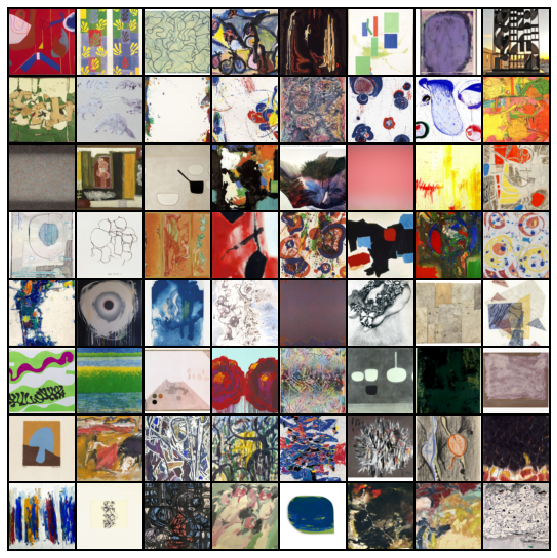

In [3]:
BATCH_SIZE = 64
IMG_SIZE = 64

norm=((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Means, Stds
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(*norm,inplace=True),
])

def unnorm(images, means, stds):
    means = torch.tensor(means).reshape(1,3,1,1)
    stds = torch.tensor(stds).reshape(1,3,1,1)
    return images * stds + means


dataset = datasets.ImageFolder(root="./Abstract_gallery",transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

def show_batch(data_loader):
    for images, labels in data_loader:
        plt.subplots(figsize=(12, 10))
        plt.axis("off")
        raw_images = unnorm(images, *norm)
        plt.imshow(make_grid(raw_images[:BATCH_SIZE], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

show_batch(dataloader)

# DCGAN

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.cnn = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.cnn(x)

generator = Generator()
generator.to(DEVICE)

Generator(
  (cnn): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

discriminator = Discriminator()
discriminator.to(DEVICE)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [6]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, 100, 1, 1, device=DEVICE)

real_label = 1.
fake_label = 0.

discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
generator_optimizer = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))

  0%|          | 0/401 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 1 - Discriminator_Loss: 0.007120 - Generator_Loss: 0.081577


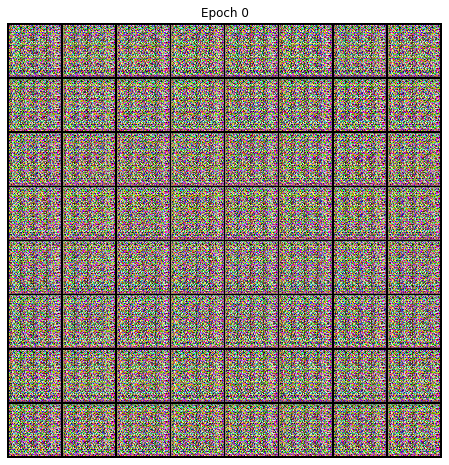

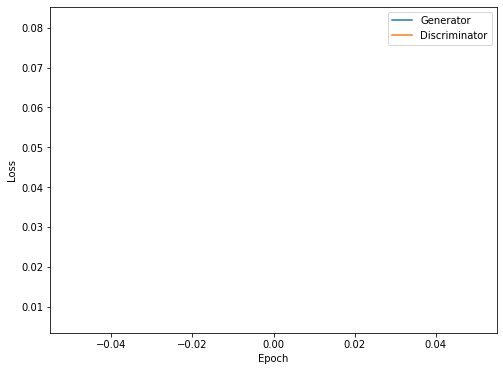

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 2 - Discriminator_Loss: 0.001188 - Generator_Loss: 0.114401


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 3 - Discriminator_Loss: 0.003288 - Generator_Loss: 0.123962


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 4 - Discriminator_Loss: 0.004881 - Generator_Loss: 0.099191


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 5 - Discriminator_Loss: 0.002115 - Generator_Loss: 0.125993


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 6 - Discriminator_Loss: 0.002320 - Generator_Loss: 0.132799


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 7 - Discriminator_Loss: 0.006392 - Generator_Loss: 0.095672


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 8 - Discriminator_Loss: 0.005805 - Generator_Loss: 0.070976


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 9 - Discriminator_Loss: 0.006630 - Generator_Loss: 0.071970


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 10 - Discriminator_Loss: 0.006748 - Generator_Loss: 0.065442


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 11 - Discriminator_Loss: 0.005727 - Generator_Loss: 0.073327


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 12 - Discriminator_Loss: 0.004895 - Generator_Loss: 0.072178


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 13 - Discriminator_Loss: 0.004964 - Generator_Loss: 0.067666


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 14 - Discriminator_Loss: 0.006282 - Generator_Loss: 0.066900


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 15 - Discriminator_Loss: 0.007727 - Generator_Loss: 0.060717


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 16 - Discriminator_Loss: 0.007515 - Generator_Loss: 0.072121


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 17 - Discriminator_Loss: 0.006965 - Generator_Loss: 0.069999


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 18 - Discriminator_Loss: 0.008653 - Generator_Loss: 0.067149


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 19 - Discriminator_Loss: 0.007304 - Generator_Loss: 0.063800


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 20 - Discriminator_Loss: 0.007169 - Generator_Loss: 0.057917


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 21 - Discriminator_Loss: 0.006728 - Generator_Loss: 0.068321


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 22 - Discriminator_Loss: 0.006710 - Generator_Loss: 0.063254


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 23 - Discriminator_Loss: 0.006154 - Generator_Loss: 0.063903


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 24 - Discriminator_Loss: 0.006774 - Generator_Loss: 0.071032


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 25 - Discriminator_Loss: 0.008037 - Generator_Loss: 0.065620


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 26 - Discriminator_Loss: 0.006898 - Generator_Loss: 0.064320


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 27 - Discriminator_Loss: 0.007042 - Generator_Loss: 0.063081


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 28 - Discriminator_Loss: 0.007754 - Generator_Loss: 0.064959


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 29 - Discriminator_Loss: 0.008594 - Generator_Loss: 0.063553


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 30 - Discriminator_Loss: 0.006821 - Generator_Loss: 0.060847


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 31 - Discriminator_Loss: 0.006551 - Generator_Loss: 0.063419


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 32 - Discriminator_Loss: 0.007099 - Generator_Loss: 0.062309


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 33 - Discriminator_Loss: 0.008650 - Generator_Loss: 0.059942


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 34 - Discriminator_Loss: 0.007833 - Generator_Loss: 0.060123


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 35 - Discriminator_Loss: 0.007397 - Generator_Loss: 0.057734


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 36 - Discriminator_Loss: 0.008761 - Generator_Loss: 0.060030


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 37 - Discriminator_Loss: 0.007318 - Generator_Loss: 0.057859


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 38 - Discriminator_Loss: 0.008333 - Generator_Loss: 0.060899


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 39 - Discriminator_Loss: 0.007499 - Generator_Loss: 0.056904


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 40 - Discriminator_Loss: 0.008579 - Generator_Loss: 0.055392


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 41 - Discriminator_Loss: 0.008691 - Generator_Loss: 0.057589


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 42 - Discriminator_Loss: 0.008939 - Generator_Loss: 0.058736


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 43 - Discriminator_Loss: 0.008772 - Generator_Loss: 0.056285


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 44 - Discriminator_Loss: 0.008952 - Generator_Loss: 0.056114


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 45 - Discriminator_Loss: 0.008808 - Generator_Loss: 0.054454


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 46 - Discriminator_Loss: 0.008659 - Generator_Loss: 0.053921


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 47 - Discriminator_Loss: 0.008795 - Generator_Loss: 0.053461


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 48 - Discriminator_Loss: 0.008739 - Generator_Loss: 0.056877


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 49 - Discriminator_Loss: 0.007900 - Generator_Loss: 0.054605


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 50 - Discriminator_Loss: 0.008886 - Generator_Loss: 0.058806


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 51 - Discriminator_Loss: 0.008432 - Generator_Loss: 0.054929


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 52 - Discriminator_Loss: 0.007743 - Generator_Loss: 0.055556


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 53 - Discriminator_Loss: 0.008158 - Generator_Loss: 0.055274


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 54 - Discriminator_Loss: 0.009529 - Generator_Loss: 0.056540


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 55 - Discriminator_Loss: 0.006563 - Generator_Loss: 0.052859


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 56 - Discriminator_Loss: 0.006825 - Generator_Loss: 0.058059


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 57 - Discriminator_Loss: 0.007262 - Generator_Loss: 0.059651


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 58 - Discriminator_Loss: 0.006053 - Generator_Loss: 0.058636


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 59 - Discriminator_Loss: 0.006551 - Generator_Loss: 0.059399


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 60 - Discriminator_Loss: 0.006028 - Generator_Loss: 0.058443


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 61 - Discriminator_Loss: 0.006997 - Generator_Loss: 0.058879


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 62 - Discriminator_Loss: 0.004690 - Generator_Loss: 0.058285


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 63 - Discriminator_Loss: 0.004473 - Generator_Loss: 0.057957


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 64 - Discriminator_Loss: 0.004769 - Generator_Loss: 0.062219


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 65 - Discriminator_Loss: 0.004032 - Generator_Loss: 0.061470


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 66 - Discriminator_Loss: 0.003857 - Generator_Loss: 0.063207


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 67 - Discriminator_Loss: 0.011646 - Generator_Loss: 0.071632


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 68 - Discriminator_Loss: 0.005069 - Generator_Loss: 0.059875


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 69 - Discriminator_Loss: 0.004025 - Generator_Loss: 0.062379


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 70 - Discriminator_Loss: 0.004507 - Generator_Loss: 0.060236


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 71 - Discriminator_Loss: 0.003546 - Generator_Loss: 0.062667


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 72 - Discriminator_Loss: 0.005673 - Generator_Loss: 0.070348


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 73 - Discriminator_Loss: 0.008444 - Generator_Loss: 0.071178


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 74 - Discriminator_Loss: 0.005165 - Generator_Loss: 0.063352


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 75 - Discriminator_Loss: 0.003663 - Generator_Loss: 0.060106


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 76 - Discriminator_Loss: 0.004096 - Generator_Loss: 0.061979


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 77 - Discriminator_Loss: 0.004225 - Generator_Loss: 0.068642


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 78 - Discriminator_Loss: 0.003236 - Generator_Loss: 0.061078


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 79 - Discriminator_Loss: 0.003500 - Generator_Loss: 0.062234


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 80 - Discriminator_Loss: 0.003608 - Generator_Loss: 0.068358


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 81 - Discriminator_Loss: 0.004521 - Generator_Loss: 0.074361


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 82 - Discriminator_Loss: 0.003248 - Generator_Loss: 0.069616


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 83 - Discriminator_Loss: 0.005455 - Generator_Loss: 0.077172


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 84 - Discriminator_Loss: 0.006455 - Generator_Loss: 0.072189


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 85 - Discriminator_Loss: 0.003482 - Generator_Loss: 0.065437


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 86 - Discriminator_Loss: 0.005648 - Generator_Loss: 0.068761


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 87 - Discriminator_Loss: 0.003365 - Generator_Loss: 0.074306


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 88 - Discriminator_Loss: 0.003887 - Generator_Loss: 0.067325


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 89 - Discriminator_Loss: 0.004564 - Generator_Loss: 0.070646


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 90 - Discriminator_Loss: 0.004043 - Generator_Loss: 0.065081


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 91 - Discriminator_Loss: 0.004201 - Generator_Loss: 0.076280


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 92 - Discriminator_Loss: 0.004787 - Generator_Loss: 0.067920


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 93 - Discriminator_Loss: 0.004397 - Generator_Loss: 0.071981


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 94 - Discriminator_Loss: 0.004930 - Generator_Loss: 0.070322


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 95 - Discriminator_Loss: 0.004308 - Generator_Loss: 0.067139


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 96 - Discriminator_Loss: 0.003022 - Generator_Loss: 0.066805


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 97 - Discriminator_Loss: 0.005525 - Generator_Loss: 0.069918


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 98 - Discriminator_Loss: 0.003720 - Generator_Loss: 0.064801


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 99 - Discriminator_Loss: 0.004253 - Generator_Loss: 0.067719


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 100 - Discriminator_Loss: 0.007533 - Generator_Loss: 0.067516


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 101 - Discriminator_Loss: 0.003251 - Generator_Loss: 0.067372


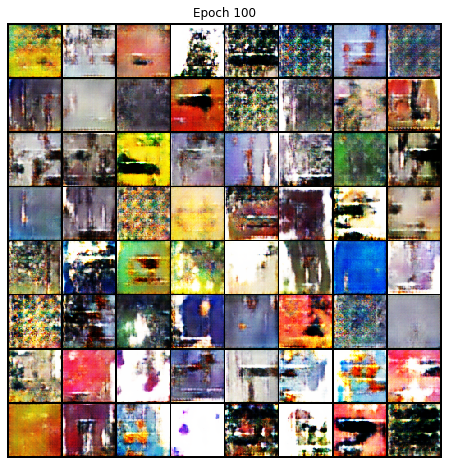

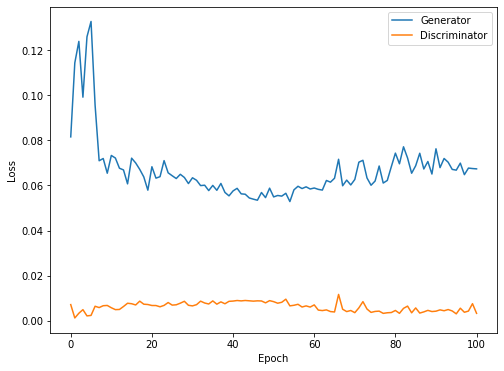

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 102 - Discriminator_Loss: 0.004652 - Generator_Loss: 0.068589


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 103 - Discriminator_Loss: 0.003333 - Generator_Loss: 0.061551


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 104 - Discriminator_Loss: 0.004658 - Generator_Loss: 0.067649


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 105 - Discriminator_Loss: 0.003349 - Generator_Loss: 0.063328


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 106 - Discriminator_Loss: 0.003006 - Generator_Loss: 0.064169


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 107 - Discriminator_Loss: 0.003078 - Generator_Loss: 0.068455


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 108 - Discriminator_Loss: 0.004862 - Generator_Loss: 0.072922


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 109 - Discriminator_Loss: 0.003617 - Generator_Loss: 0.071133


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 110 - Discriminator_Loss: 0.003204 - Generator_Loss: 0.063265


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 111 - Discriminator_Loss: 0.004291 - Generator_Loss: 0.070917


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 112 - Discriminator_Loss: 0.002870 - Generator_Loss: 0.067776


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 113 - Discriminator_Loss: 0.003258 - Generator_Loss: 0.068131


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 114 - Discriminator_Loss: 0.010995 - Generator_Loss: 0.078551


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 115 - Discriminator_Loss: 0.003342 - Generator_Loss: 0.061904


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 116 - Discriminator_Loss: 0.003022 - Generator_Loss: 0.063290


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 117 - Discriminator_Loss: 0.002960 - Generator_Loss: 0.066332


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 118 - Discriminator_Loss: 0.002693 - Generator_Loss: 0.067895


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 119 - Discriminator_Loss: 0.003835 - Generator_Loss: 0.065794


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 120 - Discriminator_Loss: 0.005713 - Generator_Loss: 0.067104


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 121 - Discriminator_Loss: 0.002786 - Generator_Loss: 0.065054


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 122 - Discriminator_Loss: 0.002884 - Generator_Loss: 0.068418


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 123 - Discriminator_Loss: 0.007003 - Generator_Loss: 0.081214


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 124 - Discriminator_Loss: 0.003206 - Generator_Loss: 0.064718


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 125 - Discriminator_Loss: 0.002905 - Generator_Loss: 0.066743


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 126 - Discriminator_Loss: 0.002736 - Generator_Loss: 0.068070


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 127 - Discriminator_Loss: 0.002740 - Generator_Loss: 0.068968


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 128 - Discriminator_Loss: 0.003871 - Generator_Loss: 0.072604


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 129 - Discriminator_Loss: 0.002801 - Generator_Loss: 0.070480


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 130 - Discriminator_Loss: 0.002656 - Generator_Loss: 0.069700


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 131 - Discriminator_Loss: 0.005858 - Generator_Loss: 0.075795


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 132 - Discriminator_Loss: 0.002957 - Generator_Loss: 0.069381


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 133 - Discriminator_Loss: 0.001993 - Generator_Loss: 0.067664


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 134 - Discriminator_Loss: 0.001833 - Generator_Loss: 0.068982


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 135 - Discriminator_Loss: 0.001712 - Generator_Loss: 0.071784


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 136 - Discriminator_Loss: 0.001969 - Generator_Loss: 0.072491


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 137 - Discriminator_Loss: 0.003721 - Generator_Loss: 0.082533


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 138 - Discriminator_Loss: 0.002485 - Generator_Loss: 0.074097


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 139 - Discriminator_Loss: 0.002022 - Generator_Loss: 0.073091


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 140 - Discriminator_Loss: 0.002000 - Generator_Loss: 0.073992


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 141 - Discriminator_Loss: 0.001796 - Generator_Loss: 0.073653


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 142 - Discriminator_Loss: 0.012850 - Generator_Loss: 0.079310


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 143 - Discriminator_Loss: 0.004605 - Generator_Loss: 0.069588


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 144 - Discriminator_Loss: 0.002676 - Generator_Loss: 0.066799


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 145 - Discriminator_Loss: 0.002295 - Generator_Loss: 0.067833


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 146 - Discriminator_Loss: 0.001681 - Generator_Loss: 0.069849


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 147 - Discriminator_Loss: 0.002147 - Generator_Loss: 0.071226


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 148 - Discriminator_Loss: 0.001650 - Generator_Loss: 0.071907


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 149 - Discriminator_Loss: 0.001440 - Generator_Loss: 0.072684


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 150 - Discriminator_Loss: 0.001546 - Generator_Loss: 0.071563


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 151 - Discriminator_Loss: 0.003094 - Generator_Loss: 0.081641


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 152 - Discriminator_Loss: 0.003832 - Generator_Loss: 0.078753


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 153 - Discriminator_Loss: 0.001558 - Generator_Loss: 0.071681


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 154 - Discriminator_Loss: 0.001508 - Generator_Loss: 0.072708


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 155 - Discriminator_Loss: 0.001228 - Generator_Loss: 0.074036


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 156 - Discriminator_Loss: 0.001257 - Generator_Loss: 0.074108


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 157 - Discriminator_Loss: 0.001456 - Generator_Loss: 0.076758


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 158 - Discriminator_Loss: 0.001265 - Generator_Loss: 0.077451


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 159 - Discriminator_Loss: 0.011295 - Generator_Loss: 0.091409


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 160 - Discriminator_Loss: 0.003195 - Generator_Loss: 0.074447


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 161 - Discriminator_Loss: 0.001939 - Generator_Loss: 0.070454


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 162 - Discriminator_Loss: 0.001817 - Generator_Loss: 0.073660


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 163 - Discriminator_Loss: 0.002596 - Generator_Loss: 0.078738


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 164 - Discriminator_Loss: 0.001493 - Generator_Loss: 0.073437


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 165 - Discriminator_Loss: 0.001179 - Generator_Loss: 0.073962


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 166 - Discriminator_Loss: 0.001421 - Generator_Loss: 0.077699


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 167 - Discriminator_Loss: 0.001138 - Generator_Loss: 0.076406


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 168 - Discriminator_Loss: 0.011718 - Generator_Loss: 0.089178


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 169 - Discriminator_Loss: 0.002985 - Generator_Loss: 0.072984


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 170 - Discriminator_Loss: 0.001785 - Generator_Loss: 0.070960


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 171 - Discriminator_Loss: 0.001496 - Generator_Loss: 0.069765


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 172 - Discriminator_Loss: 0.001921 - Generator_Loss: 0.078150


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 173 - Discriminator_Loss: 0.001136 - Generator_Loss: 0.076226


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 174 - Discriminator_Loss: 0.001498 - Generator_Loss: 0.080988


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 175 - Discriminator_Loss: 0.001018 - Generator_Loss: 0.075255


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 176 - Discriminator_Loss: 0.002081 - Generator_Loss: 0.080769


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 177 - Discriminator_Loss: 0.001375 - Generator_Loss: 0.080066


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 178 - Discriminator_Loss: 0.003078 - Generator_Loss: 0.081566


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 179 - Discriminator_Loss: 0.001371 - Generator_Loss: 0.078347


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 180 - Discriminator_Loss: 0.001054 - Generator_Loss: 0.077280


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 181 - Discriminator_Loss: 0.001181 - Generator_Loss: 0.080967


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 182 - Discriminator_Loss: 0.001073 - Generator_Loss: 0.081062


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 183 - Discriminator_Loss: 0.002745 - Generator_Loss: 0.084792


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 184 - Discriminator_Loss: 0.002139 - Generator_Loss: 0.084652


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 185 - Discriminator_Loss: 0.001419 - Generator_Loss: 0.082090


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 186 - Discriminator_Loss: 0.009573 - Generator_Loss: 0.087706


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 187 - Discriminator_Loss: 0.003219 - Generator_Loss: 0.075582


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 188 - Discriminator_Loss: 0.002099 - Generator_Loss: 0.076116


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 189 - Discriminator_Loss: 0.001234 - Generator_Loss: 0.075779


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 190 - Discriminator_Loss: 0.001167 - Generator_Loss: 0.075476


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 191 - Discriminator_Loss: 0.001099 - Generator_Loss: 0.075947


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 192 - Discriminator_Loss: 0.001294 - Generator_Loss: 0.079753


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 193 - Discriminator_Loss: 0.000919 - Generator_Loss: 0.080900


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 194 - Discriminator_Loss: 0.001651 - Generator_Loss: 0.081849


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 195 - Discriminator_Loss: 0.007385 - Generator_Loss: 0.087769


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 196 - Discriminator_Loss: 0.001576 - Generator_Loss: 0.077195


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 197 - Discriminator_Loss: 0.001153 - Generator_Loss: 0.076679


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 198 - Discriminator_Loss: 0.000990 - Generator_Loss: 0.077818


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 199 - Discriminator_Loss: 0.000981 - Generator_Loss: 0.078946


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 200 - Discriminator_Loss: 0.000778 - Generator_Loss: 0.081420


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 201 - Discriminator_Loss: 0.001478 - Generator_Loss: 0.083495


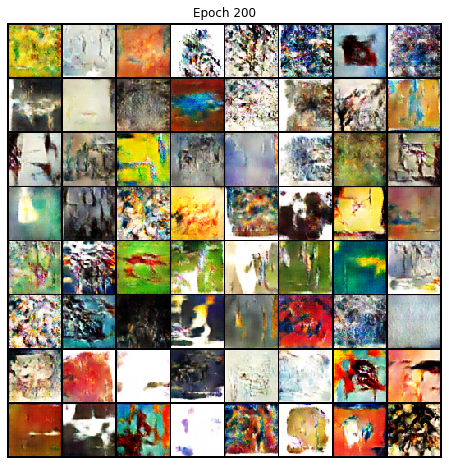

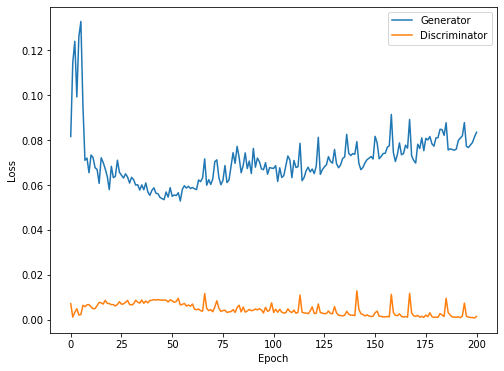

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 202 - Discriminator_Loss: 0.000829 - Generator_Loss: 0.081413


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 203 - Discriminator_Loss: 0.000766 - Generator_Loss: 0.080790


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 204 - Discriminator_Loss: 0.000694 - Generator_Loss: 0.083110


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 205 - Discriminator_Loss: 0.000853 - Generator_Loss: 0.085610


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 206 - Discriminator_Loss: 0.000690 - Generator_Loss: 0.084551


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 207 - Discriminator_Loss: 0.000554 - Generator_Loss: 0.085893


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 208 - Discriminator_Loss: 0.000794 - Generator_Loss: 0.087111


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 209 - Discriminator_Loss: 0.000626 - Generator_Loss: 0.084226


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 210 - Discriminator_Loss: 0.000813 - Generator_Loss: 0.086598


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 211 - Discriminator_Loss: 0.000784 - Generator_Loss: 0.086430


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 212 - Discriminator_Loss: 0.000685 - Generator_Loss: 0.084938


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 213 - Discriminator_Loss: 0.015696 - Generator_Loss: 0.096090


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 214 - Discriminator_Loss: 0.013294 - Generator_Loss: 0.085988


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 215 - Discriminator_Loss: 0.004655 - Generator_Loss: 0.079127


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 216 - Discriminator_Loss: 0.002092 - Generator_Loss: 0.073382


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 217 - Discriminator_Loss: 0.001701 - Generator_Loss: 0.073451


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 218 - Discriminator_Loss: 0.001215 - Generator_Loss: 0.075428


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 219 - Discriminator_Loss: 0.001088 - Generator_Loss: 0.074293


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 220 - Discriminator_Loss: 0.000985 - Generator_Loss: 0.078248


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 221 - Discriminator_Loss: 0.000890 - Generator_Loss: 0.078178


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 222 - Discriminator_Loss: 0.000941 - Generator_Loss: 0.081365


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 223 - Discriminator_Loss: 0.000975 - Generator_Loss: 0.080263


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 224 - Discriminator_Loss: 0.004852 - Generator_Loss: 0.087195


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 225 - Discriminator_Loss: 0.003543 - Generator_Loss: 0.082026


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 226 - Discriminator_Loss: 0.001200 - Generator_Loss: 0.079536


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 227 - Discriminator_Loss: 0.000813 - Generator_Loss: 0.080196


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 228 - Discriminator_Loss: 0.000873 - Generator_Loss: 0.083652


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 229 - Discriminator_Loss: 0.000874 - Generator_Loss: 0.083933


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 230 - Discriminator_Loss: 0.000845 - Generator_Loss: 0.083150


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 231 - Discriminator_Loss: 0.000647 - Generator_Loss: 0.084185


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 232 - Discriminator_Loss: 0.000866 - Generator_Loss: 0.087069


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 233 - Discriminator_Loss: 0.000670 - Generator_Loss: 0.085181


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 234 - Discriminator_Loss: 0.000562 - Generator_Loss: 0.085033


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 235 - Discriminator_Loss: 0.000629 - Generator_Loss: 0.089513


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 236 - Discriminator_Loss: 0.000620 - Generator_Loss: 0.086970


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 237 - Discriminator_Loss: 0.000600 - Generator_Loss: 0.089306


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 238 - Discriminator_Loss: 0.000674 - Generator_Loss: 0.090943


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 239 - Discriminator_Loss: 0.000712 - Generator_Loss: 0.088776


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 240 - Discriminator_Loss: 0.000858 - Generator_Loss: 0.091197


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 241 - Discriminator_Loss: 0.021217 - Generator_Loss: 0.097995


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 242 - Discriminator_Loss: 0.005130 - Generator_Loss: 0.090733


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 243 - Discriminator_Loss: 0.002050 - Generator_Loss: 0.081699


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 244 - Discriminator_Loss: 0.001278 - Generator_Loss: 0.079004


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 245 - Discriminator_Loss: 0.000953 - Generator_Loss: 0.078788


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 246 - Discriminator_Loss: 0.000882 - Generator_Loss: 0.082046


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 247 - Discriminator_Loss: 0.000942 - Generator_Loss: 0.086448


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 248 - Discriminator_Loss: 0.000787 - Generator_Loss: 0.082588


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 249 - Discriminator_Loss: 0.000656 - Generator_Loss: 0.085747


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 250 - Discriminator_Loss: 0.008274 - Generator_Loss: 0.087326


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 251 - Discriminator_Loss: 0.001832 - Generator_Loss: 0.082685


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 252 - Discriminator_Loss: 0.001114 - Generator_Loss: 0.084131


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 253 - Discriminator_Loss: 0.000809 - Generator_Loss: 0.084515


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 254 - Discriminator_Loss: 0.000711 - Generator_Loss: 0.083880


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 255 - Discriminator_Loss: 0.000738 - Generator_Loss: 0.084967


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 256 - Discriminator_Loss: 0.000736 - Generator_Loss: 0.087279


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 257 - Discriminator_Loss: 0.000624 - Generator_Loss: 0.085592


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 258 - Discriminator_Loss: 0.000584 - Generator_Loss: 0.086425


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 259 - Discriminator_Loss: 0.000629 - Generator_Loss: 0.088119


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 260 - Discriminator_Loss: 0.000601 - Generator_Loss: 0.088333


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 261 - Discriminator_Loss: 0.000533 - Generator_Loss: 0.089276


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 262 - Discriminator_Loss: 0.000631 - Generator_Loss: 0.091391


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 263 - Discriminator_Loss: 0.000548 - Generator_Loss: 0.090367


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 264 - Discriminator_Loss: 0.000550 - Generator_Loss: 0.090200


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 265 - Discriminator_Loss: 0.000515 - Generator_Loss: 0.092059


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 266 - Discriminator_Loss: 0.000502 - Generator_Loss: 0.091296


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 267 - Discriminator_Loss: 0.000502 - Generator_Loss: 0.092415


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 268 - Discriminator_Loss: 0.000780 - Generator_Loss: 0.097234


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 269 - Discriminator_Loss: 0.012169 - Generator_Loss: 0.136667


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 270 - Discriminator_Loss: 0.003961 - Generator_Loss: 0.100571


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 271 - Discriminator_Loss: 0.001482 - Generator_Loss: 0.090312


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 272 - Discriminator_Loss: 0.001160 - Generator_Loss: 0.088154


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 273 - Discriminator_Loss: 0.000940 - Generator_Loss: 0.086221


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 274 - Discriminator_Loss: 0.000813 - Generator_Loss: 0.088866


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 275 - Discriminator_Loss: 0.000742 - Generator_Loss: 0.089764


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 276 - Discriminator_Loss: 0.000864 - Generator_Loss: 0.092277


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 277 - Discriminator_Loss: 0.000796 - Generator_Loss: 0.092227


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 278 - Discriminator_Loss: 0.000544 - Generator_Loss: 0.092272


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 279 - Discriminator_Loss: 0.000574 - Generator_Loss: 0.091724


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 280 - Discriminator_Loss: 0.000633 - Generator_Loss: 0.089190


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 281 - Discriminator_Loss: 0.004785 - Generator_Loss: 0.110626


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 282 - Discriminator_Loss: 0.001004 - Generator_Loss: 0.096791


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 283 - Discriminator_Loss: 0.000998 - Generator_Loss: 0.100789


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 284 - Discriminator_Loss: 0.001075 - Generator_Loss: 0.101875


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 285 - Discriminator_Loss: 0.007711 - Generator_Loss: 0.110120


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 286 - Discriminator_Loss: 0.001103 - Generator_Loss: 0.093640


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 287 - Discriminator_Loss: 0.000917 - Generator_Loss: 0.086882


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 288 - Discriminator_Loss: 0.000773 - Generator_Loss: 0.090212


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 289 - Discriminator_Loss: 0.000948 - Generator_Loss: 0.094338


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 290 - Discriminator_Loss: 0.001285 - Generator_Loss: 0.098871


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 291 - Discriminator_Loss: 0.000741 - Generator_Loss: 0.097432


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 292 - Discriminator_Loss: 0.000679 - Generator_Loss: 0.092488


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 293 - Discriminator_Loss: 0.000579 - Generator_Loss: 0.093424


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 294 - Discriminator_Loss: 0.000492 - Generator_Loss: 0.090937


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 295 - Discriminator_Loss: 0.000458 - Generator_Loss: 0.095645


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 296 - Discriminator_Loss: 0.000515 - Generator_Loss: 0.094474


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 297 - Discriminator_Loss: 0.000568 - Generator_Loss: 0.096024


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 298 - Discriminator_Loss: 0.001482 - Generator_Loss: 0.120341


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 299 - Discriminator_Loss: 0.000679 - Generator_Loss: 0.101008


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 300 - Discriminator_Loss: 0.001863 - Generator_Loss: 0.110548


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 301 - Discriminator_Loss: 0.000580 - Generator_Loss: 0.095646


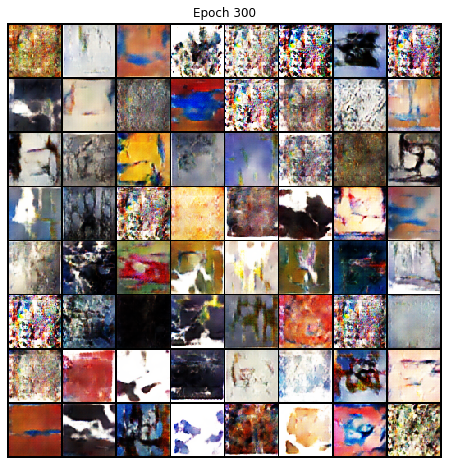

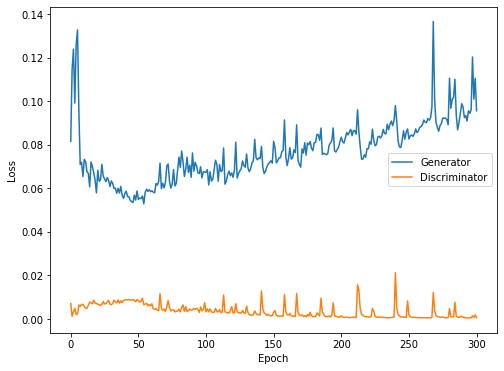

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 302 - Discriminator_Loss: 0.000468 - Generator_Loss: 0.096615


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 303 - Discriminator_Loss: 0.000589 - Generator_Loss: 0.105138


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 304 - Discriminator_Loss: 0.000718 - Generator_Loss: 0.115856


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 305 - Discriminator_Loss: 0.000601 - Generator_Loss: 0.114992


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 306 - Discriminator_Loss: 0.000479 - Generator_Loss: 0.099781


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 307 - Discriminator_Loss: 0.000527 - Generator_Loss: 0.099358


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 308 - Discriminator_Loss: 0.001585 - Generator_Loss: 0.120968


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 309 - Discriminator_Loss: 0.000515 - Generator_Loss: 0.101407


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 310 - Discriminator_Loss: 0.000437 - Generator_Loss: 0.097827


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 311 - Discriminator_Loss: 0.000544 - Generator_Loss: 0.124207


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 312 - Discriminator_Loss: 0.000404 - Generator_Loss: 0.103956


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 313 - Discriminator_Loss: 0.000657 - Generator_Loss: 0.103884


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 314 - Discriminator_Loss: 0.013549 - Generator_Loss: 0.127829


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 315 - Discriminator_Loss: 0.001940 - Generator_Loss: 0.094722


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 316 - Discriminator_Loss: 0.001204 - Generator_Loss: 0.090198


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 317 - Discriminator_Loss: 0.000894 - Generator_Loss: 0.094323


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 318 - Discriminator_Loss: 0.001210 - Generator_Loss: 0.098211


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 319 - Discriminator_Loss: 0.001640 - Generator_Loss: 0.113955


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 320 - Discriminator_Loss: 0.000757 - Generator_Loss: 0.097858


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 321 - Discriminator_Loss: 0.000598 - Generator_Loss: 0.094591


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 322 - Discriminator_Loss: 0.000503 - Generator_Loss: 0.093408


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 323 - Discriminator_Loss: 0.000469 - Generator_Loss: 0.094668


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 324 - Discriminator_Loss: 0.000701 - Generator_Loss: 0.102248


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 325 - Discriminator_Loss: 0.002366 - Generator_Loss: 0.125914


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 326 - Discriminator_Loss: 0.000650 - Generator_Loss: 0.099762


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 327 - Discriminator_Loss: 0.000612 - Generator_Loss: 0.106421


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 328 - Discriminator_Loss: 0.000548 - Generator_Loss: 0.105143


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 329 - Discriminator_Loss: 0.000815 - Generator_Loss: 0.105051


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 330 - Discriminator_Loss: 0.000480 - Generator_Loss: 0.100479


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 331 - Discriminator_Loss: 0.000497 - Generator_Loss: 0.100275


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 332 - Discriminator_Loss: 0.000465 - Generator_Loss: 0.100449


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 333 - Discriminator_Loss: 0.000438 - Generator_Loss: 0.102438


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 334 - Discriminator_Loss: 0.000485 - Generator_Loss: 0.105539


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 335 - Discriminator_Loss: 0.000860 - Generator_Loss: 0.119646


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 336 - Discriminator_Loss: 0.000673 - Generator_Loss: 0.114018


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 337 - Discriminator_Loss: 0.008474 - Generator_Loss: 0.129185


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 338 - Discriminator_Loss: 0.003049 - Generator_Loss: 0.114453


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 339 - Discriminator_Loss: 0.001559 - Generator_Loss: 0.141785


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 340 - Discriminator_Loss: 0.000878 - Generator_Loss: 0.102101


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 341 - Discriminator_Loss: 0.000746 - Generator_Loss: 0.092441


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 342 - Discriminator_Loss: 0.000829 - Generator_Loss: 0.107930


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 343 - Discriminator_Loss: 0.000746 - Generator_Loss: 0.109650


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 344 - Discriminator_Loss: 0.000557 - Generator_Loss: 0.097413


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 345 - Discriminator_Loss: 0.003344 - Generator_Loss: 0.117023


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 346 - Discriminator_Loss: 0.001052 - Generator_Loss: 0.108435


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 347 - Discriminator_Loss: 0.000633 - Generator_Loss: 0.095690


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 348 - Discriminator_Loss: 0.000493 - Generator_Loss: 0.093892


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 349 - Discriminator_Loss: 0.000467 - Generator_Loss: 0.094797


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 350 - Discriminator_Loss: 0.000510 - Generator_Loss: 0.098636


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 351 - Discriminator_Loss: 0.000471 - Generator_Loss: 0.097339


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 352 - Discriminator_Loss: 0.000422 - Generator_Loss: 0.100462


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 353 - Discriminator_Loss: 0.000444 - Generator_Loss: 0.096942


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 354 - Discriminator_Loss: 0.000590 - Generator_Loss: 0.138864


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 355 - Discriminator_Loss: 0.000494 - Generator_Loss: 0.102926


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 356 - Discriminator_Loss: 0.000564 - Generator_Loss: 0.106171


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 357 - Discriminator_Loss: 0.000456 - Generator_Loss: 0.109695


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 358 - Discriminator_Loss: 0.000407 - Generator_Loss: 0.102225


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 359 - Discriminator_Loss: 0.000392 - Generator_Loss: 0.103264


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 360 - Discriminator_Loss: 0.000311 - Generator_Loss: 0.106019


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 361 - Discriminator_Loss: 0.000379 - Generator_Loss: 0.107089


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 362 - Discriminator_Loss: 0.000340 - Generator_Loss: 0.106569


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 363 - Discriminator_Loss: 0.000379 - Generator_Loss: 0.112830


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 364 - Discriminator_Loss: 0.000528 - Generator_Loss: 0.116789


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 365 - Discriminator_Loss: 0.021445 - Generator_Loss: 0.144597


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 366 - Discriminator_Loss: 0.002690 - Generator_Loss: 0.127576


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 367 - Discriminator_Loss: 0.001553 - Generator_Loss: 0.106123


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 368 - Discriminator_Loss: 0.002226 - Generator_Loss: 0.101849


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 369 - Discriminator_Loss: 0.001299 - Generator_Loss: 0.107964


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 370 - Discriminator_Loss: 0.000990 - Generator_Loss: 0.104475


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 371 - Discriminator_Loss: 0.000825 - Generator_Loss: 0.094616


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 372 - Discriminator_Loss: 0.001212 - Generator_Loss: 0.133794


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 373 - Discriminator_Loss: 0.000711 - Generator_Loss: 0.099277


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 374 - Discriminator_Loss: 0.000592 - Generator_Loss: 0.098954


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 375 - Discriminator_Loss: 0.000539 - Generator_Loss: 0.097879


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 376 - Discriminator_Loss: 0.000650 - Generator_Loss: 0.102228


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 377 - Discriminator_Loss: 0.000570 - Generator_Loss: 0.100340


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 378 - Discriminator_Loss: 0.001273 - Generator_Loss: 0.118113


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 379 - Discriminator_Loss: 0.000578 - Generator_Loss: 0.097525


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 380 - Discriminator_Loss: 0.000493 - Generator_Loss: 0.100766


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 381 - Discriminator_Loss: 0.000529 - Generator_Loss: 0.105466


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 382 - Discriminator_Loss: 0.000609 - Generator_Loss: 0.107402


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 383 - Discriminator_Loss: 0.000412 - Generator_Loss: 0.098284


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 384 - Discriminator_Loss: 0.000717 - Generator_Loss: 0.113795


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 385 - Discriminator_Loss: 0.006061 - Generator_Loss: 0.177881


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 386 - Discriminator_Loss: 0.001468 - Generator_Loss: 0.115000


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 387 - Discriminator_Loss: 0.000795 - Generator_Loss: 0.103175


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 388 - Discriminator_Loss: 0.000581 - Generator_Loss: 0.098885


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 389 - Discriminator_Loss: 0.000536 - Generator_Loss: 0.102904


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 390 - Discriminator_Loss: 0.000447 - Generator_Loss: 0.099161


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 391 - Discriminator_Loss: 0.000468 - Generator_Loss: 0.098189


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 392 - Discriminator_Loss: 0.000477 - Generator_Loss: 0.099314


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 393 - Discriminator_Loss: 0.000536 - Generator_Loss: 0.104752


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 394 - Discriminator_Loss: 0.000410 - Generator_Loss: 0.102869


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 395 - Discriminator_Loss: 0.009772 - Generator_Loss: 0.167802


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 396 - Discriminator_Loss: 0.001813 - Generator_Loss: 0.100560


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 397 - Discriminator_Loss: 0.000911 - Generator_Loss: 0.092918


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 398 - Discriminator_Loss: 0.000718 - Generator_Loss: 0.095782


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 399 - Discriminator_Loss: 0.000625 - Generator_Loss: 0.094487


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 400 - Discriminator_Loss: 0.000982 - Generator_Loss: 0.112510


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 401 - Discriminator_Loss: 0.000567 - Generator_Loss: 0.105106


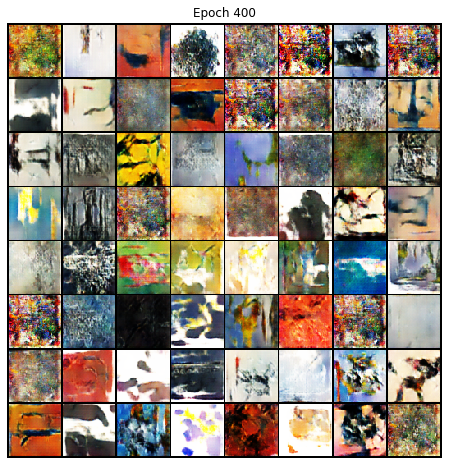

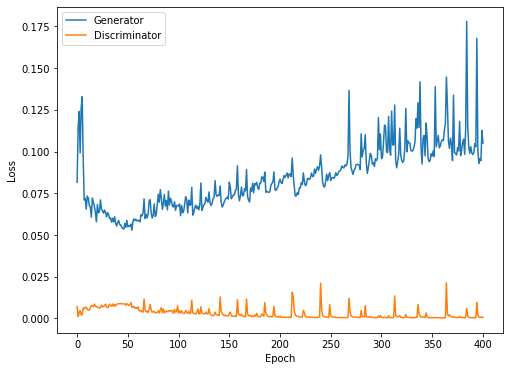

In [7]:
img_list = []
g_losses, d_losses = [], []
total = 0

def plot_loss(G_losses, D_losses):
    plt.figure(figsize=(8, 6))
    plt.plot(G_losses,label="Generator")
    plt.plot(D_losses,label="Discriminator")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

def plot_images(imgs, epoch):
    plt.subplots(figsize=(10, 8))
    plt.axis("off")
    plt.title(f"Epoch {epoch}")
    raw_images = unnorm(imgs, *norm)
    plt.imshow(make_grid(raw_images[:BATCH_SIZE], nrow=8).permute(1, 2, 0).clamp(0,1))
    plt.show()

for epoch in tqdm(range(401)):
    g_loss = 0.0
    d_loss = 0.0
    total = 0
    for i, data in tqdm(enumerate(dataloader, 0), total=len(dataloader)):
        # Train Discriminator
        discriminator.zero_grad()
        # Real
        real_images = data[0].to(DEVICE)
        batch_size = real_images.size(0)
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=DEVICE)
        output = discriminator(real_images).view(-1)
        dl_real = criterion(output, label)
        dl_real.backward()
        # Fake
        noise = torch.randn(batch_size, 100, 1, 1, device=DEVICE)
        fake = generator(noise)
        label.fill_(fake_label)
        output = discriminator(fake.detach()).view(-1)
        dl_fake = criterion(output, label)
        dl_fake.backward()
        dl = dl_real + dl_fake
        discriminator_optimizer.step()

        # Train Generator
        generator.zero_grad()
        label.fill_(real_label)
        output = discriminator(fake).view(-1)
        gl = criterion(output, label)
        gl.backward()
        generator_optimizer.step()

        g_loss += gl.item()
        d_loss += dl.item()
        total += batch_size

    avg_g_loss = g_loss / total
    g_losses.append(avg_g_loss)
    avg_d_loss = d_loss / total
    d_losses.append(avg_d_loss)

    print(f"Epoch: {epoch + 1} - Discriminator_Loss: {avg_d_loss:.6f} - Generator_Loss: {avg_g_loss:.6f}")

    with torch.no_grad():
        fake = generator(fixed_noise).detach().cpu()
    imgs = vutils.make_grid(unnorm(fake, *norm), padding=2, normalize=True)
    img_list.append(imgs)
    if epoch % 100 == 0:
        plot_images(fake, epoch)
        plot_loss(g_losses, d_losses)

# 1 WGAN + More

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
#             nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
generator = Generator()
generator.to(DEVICE)
discriminator = Discriminator()
discriminator.to(DEVICE)

criterion = nn.BCELoss()
fixed_noise = torch.randn(64, 100, 1, 1, device=DEVICE)
real_label = 1.
fake_label = 0.
# discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
# generator_optimizer = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))

discriminator_optimizer = optim.RMSprop(discriminator.parameters(), lr=0.00005, weight_decay=1e-5)
generator_optimizer = optim.RMSprop(generator.parameters(), lr=0.00005)

  0%|          | 0/401 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 1 - Discriminator_Loss: -0.000030 - Generator_Loss: -0.000072


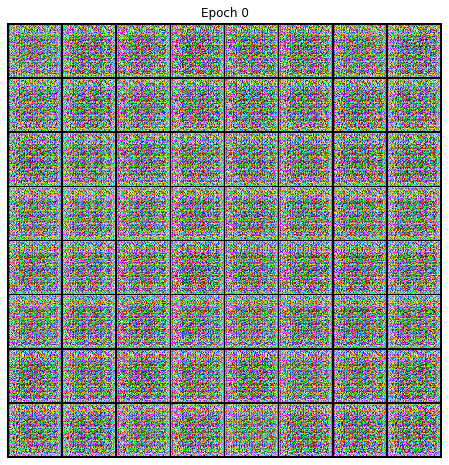

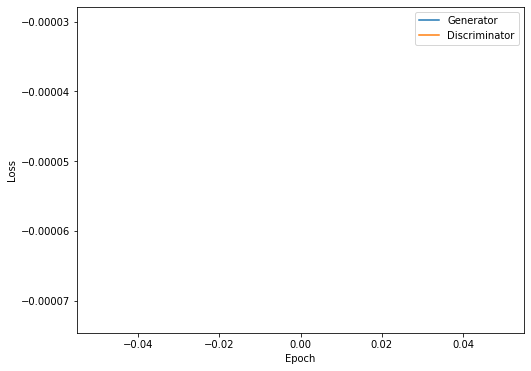

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 2 - Discriminator_Loss: -0.000045 - Generator_Loss: -0.000070


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 3 - Discriminator_Loss: -0.000068 - Generator_Loss: -0.000096


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 4 - Discriminator_Loss: -0.000014 - Generator_Loss: -0.000094


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 5 - Discriminator_Loss: -0.000065 - Generator_Loss: -0.000081


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 6 - Discriminator_Loss: -0.000079 - Generator_Loss: -0.000094


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 7 - Discriminator_Loss: -0.000149 - Generator_Loss: -0.000038


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 8 - Discriminator_Loss: -0.000287 - Generator_Loss: 0.000102


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 9 - Discriminator_Loss: -0.000505 - Generator_Loss: 0.000431


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 10 - Discriminator_Loss: -0.000256 - Generator_Loss: 0.000512


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 11 - Discriminator_Loss: -0.000391 - Generator_Loss: 0.000640


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 12 - Discriminator_Loss: -0.000775 - Generator_Loss: 0.001105


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 13 - Discriminator_Loss: -0.001546 - Generator_Loss: 0.001740


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 14 - Discriminator_Loss: -0.002936 - Generator_Loss: 0.002847


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 15 - Discriminator_Loss: -0.005118 - Generator_Loss: 0.003531


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 16 - Discriminator_Loss: -0.007323 - Generator_Loss: 0.004301


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 17 - Discriminator_Loss: -0.007845 - Generator_Loss: 0.004522


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 18 - Discriminator_Loss: -0.008654 - Generator_Loss: 0.004874


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 19 - Discriminator_Loss: -0.009250 - Generator_Loss: 0.005325


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 20 - Discriminator_Loss: -0.008851 - Generator_Loss: 0.005223


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 21 - Discriminator_Loss: -0.009582 - Generator_Loss: 0.005438


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 22 - Discriminator_Loss: -0.009901 - Generator_Loss: 0.005576


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 23 - Discriminator_Loss: -0.010074 - Generator_Loss: 0.005583


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 24 - Discriminator_Loss: -0.010805 - Generator_Loss: 0.005897


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 25 - Discriminator_Loss: -0.010468 - Generator_Loss: 0.005740


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 26 - Discriminator_Loss: -0.010557 - Generator_Loss: 0.005986


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 27 - Discriminator_Loss: -0.010783 - Generator_Loss: 0.006122


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 28 - Discriminator_Loss: -0.010497 - Generator_Loss: 0.006028


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 29 - Discriminator_Loss: -0.011241 - Generator_Loss: 0.006183


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 30 - Discriminator_Loss: -0.009884 - Generator_Loss: 0.005784


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 31 - Discriminator_Loss: -0.010263 - Generator_Loss: 0.005823


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 32 - Discriminator_Loss: -0.010450 - Generator_Loss: 0.006045


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 33 - Discriminator_Loss: -0.010285 - Generator_Loss: 0.005720


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 34 - Discriminator_Loss: -0.009530 - Generator_Loss: 0.005720


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 35 - Discriminator_Loss: -0.010444 - Generator_Loss: 0.005958


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 36 - Discriminator_Loss: -0.009496 - Generator_Loss: 0.005551


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 37 - Discriminator_Loss: -0.009555 - Generator_Loss: 0.005544


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 38 - Discriminator_Loss: -0.009864 - Generator_Loss: 0.005732


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 39 - Discriminator_Loss: -0.009203 - Generator_Loss: 0.005483


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 40 - Discriminator_Loss: -0.010029 - Generator_Loss: 0.005766


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 41 - Discriminator_Loss: -0.009355 - Generator_Loss: 0.005376


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 42 - Discriminator_Loss: -0.009220 - Generator_Loss: 0.005513


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 43 - Discriminator_Loss: -0.009210 - Generator_Loss: 0.005541


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 44 - Discriminator_Loss: -0.008787 - Generator_Loss: 0.005211


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 45 - Discriminator_Loss: -0.009353 - Generator_Loss: 0.005384


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 46 - Discriminator_Loss: -0.009848 - Generator_Loss: 0.005666


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 47 - Discriminator_Loss: -0.008966 - Generator_Loss: 0.005186


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 48 - Discriminator_Loss: -0.009320 - Generator_Loss: 0.005373


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 49 - Discriminator_Loss: -0.009105 - Generator_Loss: 0.005468


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 50 - Discriminator_Loss: -0.008503 - Generator_Loss: 0.004931


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 51 - Discriminator_Loss: -0.009567 - Generator_Loss: 0.005325


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 52 - Discriminator_Loss: -0.008550 - Generator_Loss: 0.005112


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 53 - Discriminator_Loss: -0.008954 - Generator_Loss: 0.005294


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 54 - Discriminator_Loss: -0.010223 - Generator_Loss: 0.005781


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 55 - Discriminator_Loss: -0.008779 - Generator_Loss: 0.005249


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 56 - Discriminator_Loss: -0.009533 - Generator_Loss: 0.005591


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 57 - Discriminator_Loss: -0.008933 - Generator_Loss: 0.005231


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 58 - Discriminator_Loss: -0.009425 - Generator_Loss: 0.005505


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 59 - Discriminator_Loss: -0.008356 - Generator_Loss: 0.005332


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 60 - Discriminator_Loss: -0.009557 - Generator_Loss: 0.005517


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 61 - Discriminator_Loss: -0.009380 - Generator_Loss: 0.005353


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 62 - Discriminator_Loss: -0.009489 - Generator_Loss: 0.005486


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 63 - Discriminator_Loss: -0.009646 - Generator_Loss: 0.005645


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 64 - Discriminator_Loss: -0.009170 - Generator_Loss: 0.005397


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 65 - Discriminator_Loss: -0.008888 - Generator_Loss: 0.005337


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 66 - Discriminator_Loss: -0.008949 - Generator_Loss: 0.005103


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 67 - Discriminator_Loss: -0.009951 - Generator_Loss: 0.005764


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 68 - Discriminator_Loss: -0.009487 - Generator_Loss: 0.005505


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 69 - Discriminator_Loss: -0.008797 - Generator_Loss: 0.005233


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 70 - Discriminator_Loss: -0.008490 - Generator_Loss: 0.005262


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 71 - Discriminator_Loss: -0.009248 - Generator_Loss: 0.005180


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 72 - Discriminator_Loss: -0.009924 - Generator_Loss: 0.005596


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 73 - Discriminator_Loss: -0.009265 - Generator_Loss: 0.005536


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 74 - Discriminator_Loss: -0.009383 - Generator_Loss: 0.005418


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 75 - Discriminator_Loss: -0.009389 - Generator_Loss: 0.005456


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 76 - Discriminator_Loss: -0.009229 - Generator_Loss: 0.005599


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 77 - Discriminator_Loss: -0.009185 - Generator_Loss: 0.005308


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 78 - Discriminator_Loss: -0.009828 - Generator_Loss: 0.005515


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 79 - Discriminator_Loss: -0.010775 - Generator_Loss: 0.006063


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 80 - Discriminator_Loss: -0.008319 - Generator_Loss: 0.005143


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 81 - Discriminator_Loss: -0.009872 - Generator_Loss: 0.005628


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 82 - Discriminator_Loss: -0.009369 - Generator_Loss: 0.005303


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 83 - Discriminator_Loss: -0.009855 - Generator_Loss: 0.005678


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 84 - Discriminator_Loss: -0.010152 - Generator_Loss: 0.005803


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 85 - Discriminator_Loss: -0.009972 - Generator_Loss: 0.005515


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 86 - Discriminator_Loss: -0.009287 - Generator_Loss: 0.005219


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 87 - Discriminator_Loss: -0.009436 - Generator_Loss: 0.005449


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 88 - Discriminator_Loss: -0.009252 - Generator_Loss: 0.005261


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 89 - Discriminator_Loss: -0.009869 - Generator_Loss: 0.005851


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 90 - Discriminator_Loss: -0.009306 - Generator_Loss: 0.005362


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 91 - Discriminator_Loss: -0.009251 - Generator_Loss: 0.005207


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 92 - Discriminator_Loss: -0.010244 - Generator_Loss: 0.005696


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 93 - Discriminator_Loss: -0.009511 - Generator_Loss: 0.005184


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 94 - Discriminator_Loss: -0.009592 - Generator_Loss: 0.005445


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 95 - Discriminator_Loss: -0.009936 - Generator_Loss: 0.005522


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 96 - Discriminator_Loss: -0.009378 - Generator_Loss: 0.005289


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 97 - Discriminator_Loss: -0.009383 - Generator_Loss: 0.005502


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 98 - Discriminator_Loss: -0.010007 - Generator_Loss: 0.005596


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 99 - Discriminator_Loss: -0.010387 - Generator_Loss: 0.005874


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 100 - Discriminator_Loss: -0.009919 - Generator_Loss: 0.005595


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 101 - Discriminator_Loss: -0.009025 - Generator_Loss: 0.005355


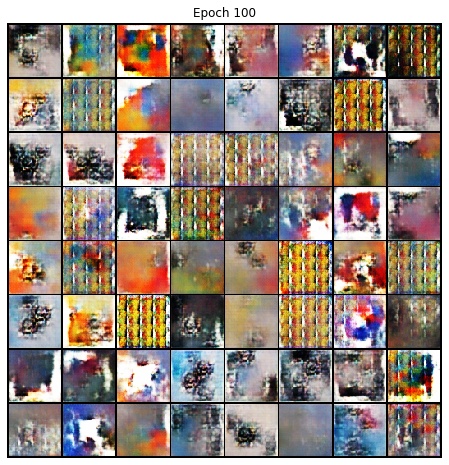

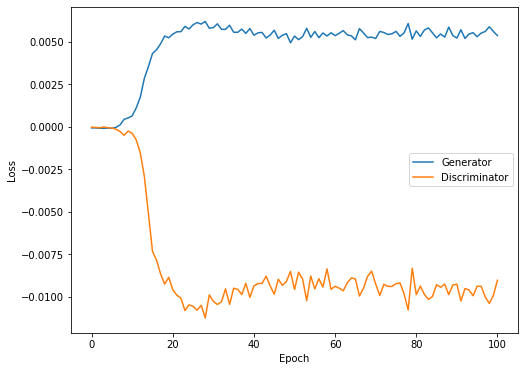

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 102 - Discriminator_Loss: -0.009731 - Generator_Loss: 0.005544


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 103 - Discriminator_Loss: -0.009815 - Generator_Loss: 0.005422


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 104 - Discriminator_Loss: -0.009780 - Generator_Loss: 0.005745


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 105 - Discriminator_Loss: -0.009683 - Generator_Loss: 0.005543


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 106 - Discriminator_Loss: -0.009852 - Generator_Loss: 0.005495


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 107 - Discriminator_Loss: -0.010158 - Generator_Loss: 0.005287


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 108 - Discriminator_Loss: -0.010293 - Generator_Loss: 0.005902


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 109 - Discriminator_Loss: -0.009609 - Generator_Loss: 0.005450


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 110 - Discriminator_Loss: -0.010010 - Generator_Loss: 0.005471


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 111 - Discriminator_Loss: -0.009993 - Generator_Loss: 0.005531


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 112 - Discriminator_Loss: -0.010113 - Generator_Loss: 0.005723


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 113 - Discriminator_Loss: -0.009265 - Generator_Loss: 0.005289


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 114 - Discriminator_Loss: -0.010045 - Generator_Loss: 0.005416


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 115 - Discriminator_Loss: -0.010102 - Generator_Loss: 0.005487


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 116 - Discriminator_Loss: -0.010056 - Generator_Loss: 0.005575


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 117 - Discriminator_Loss: -0.009391 - Generator_Loss: 0.005298


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 118 - Discriminator_Loss: -0.009724 - Generator_Loss: 0.005127


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 119 - Discriminator_Loss: -0.009677 - Generator_Loss: 0.005446


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 120 - Discriminator_Loss: -0.009806 - Generator_Loss: 0.005297


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 121 - Discriminator_Loss: -0.009401 - Generator_Loss: 0.005112


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 122 - Discriminator_Loss: -0.010801 - Generator_Loss: 0.005922


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 123 - Discriminator_Loss: -0.010409 - Generator_Loss: 0.005475


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 124 - Discriminator_Loss: -0.009545 - Generator_Loss: 0.005104


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 125 - Discriminator_Loss: -0.009522 - Generator_Loss: 0.005248


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 126 - Discriminator_Loss: -0.010310 - Generator_Loss: 0.005513


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 127 - Discriminator_Loss: -0.009998 - Generator_Loss: 0.005551


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 128 - Discriminator_Loss: -0.010054 - Generator_Loss: 0.005481


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 129 - Discriminator_Loss: -0.009700 - Generator_Loss: 0.005470


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 130 - Discriminator_Loss: -0.009859 - Generator_Loss: 0.005410


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 131 - Discriminator_Loss: -0.010092 - Generator_Loss: 0.005456


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 132 - Discriminator_Loss: -0.009500 - Generator_Loss: 0.005122


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 133 - Discriminator_Loss: -0.009413 - Generator_Loss: 0.005201


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 134 - Discriminator_Loss: -0.010171 - Generator_Loss: 0.005195


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 135 - Discriminator_Loss: -0.010044 - Generator_Loss: 0.005618


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 136 - Discriminator_Loss: -0.009668 - Generator_Loss: 0.005150


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 137 - Discriminator_Loss: -0.010250 - Generator_Loss: 0.005413


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 138 - Discriminator_Loss: -0.009679 - Generator_Loss: 0.005069


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 139 - Discriminator_Loss: -0.010050 - Generator_Loss: 0.005247


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 140 - Discriminator_Loss: -0.009775 - Generator_Loss: 0.005377


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 141 - Discriminator_Loss: -0.008932 - Generator_Loss: 0.005209


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 142 - Discriminator_Loss: -0.009771 - Generator_Loss: 0.005304


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 143 - Discriminator_Loss: -0.010264 - Generator_Loss: 0.005527


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 144 - Discriminator_Loss: -0.009320 - Generator_Loss: 0.005041


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 145 - Discriminator_Loss: -0.009436 - Generator_Loss: 0.005182


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 146 - Discriminator_Loss: -0.009486 - Generator_Loss: 0.005071


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 147 - Discriminator_Loss: -0.009842 - Generator_Loss: 0.005394


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 148 - Discriminator_Loss: -0.009387 - Generator_Loss: 0.005023


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 149 - Discriminator_Loss: -0.008704 - Generator_Loss: 0.004801


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 150 - Discriminator_Loss: -0.010014 - Generator_Loss: 0.005288


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 151 - Discriminator_Loss: -0.008931 - Generator_Loss: 0.004672


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 152 - Discriminator_Loss: -0.009820 - Generator_Loss: 0.005148


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 153 - Discriminator_Loss: -0.009106 - Generator_Loss: 0.004836


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 154 - Discriminator_Loss: -0.010014 - Generator_Loss: 0.005137


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 155 - Discriminator_Loss: -0.009204 - Generator_Loss: 0.004843


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 156 - Discriminator_Loss: -0.009281 - Generator_Loss: 0.005024


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 157 - Discriminator_Loss: -0.009075 - Generator_Loss: 0.004824


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 158 - Discriminator_Loss: -0.009827 - Generator_Loss: 0.005202


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 159 - Discriminator_Loss: -0.009084 - Generator_Loss: 0.004809


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 160 - Discriminator_Loss: -0.009739 - Generator_Loss: 0.004951


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 161 - Discriminator_Loss: -0.009091 - Generator_Loss: 0.004768


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 162 - Discriminator_Loss: -0.009672 - Generator_Loss: 0.005000


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 163 - Discriminator_Loss: -0.008768 - Generator_Loss: 0.004667


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 164 - Discriminator_Loss: -0.009635 - Generator_Loss: 0.004949


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 165 - Discriminator_Loss: -0.009338 - Generator_Loss: 0.004769


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 166 - Discriminator_Loss: -0.008756 - Generator_Loss: 0.004663


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 167 - Discriminator_Loss: -0.009049 - Generator_Loss: 0.004739


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 168 - Discriminator_Loss: -0.009728 - Generator_Loss: 0.004918


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 169 - Discriminator_Loss: -0.009031 - Generator_Loss: 0.004635


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 170 - Discriminator_Loss: -0.009321 - Generator_Loss: 0.004573


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 171 - Discriminator_Loss: -0.009244 - Generator_Loss: 0.004661


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 172 - Discriminator_Loss: -0.009109 - Generator_Loss: 0.004592


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 173 - Discriminator_Loss: -0.009541 - Generator_Loss: 0.005038


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 174 - Discriminator_Loss: -0.008529 - Generator_Loss: 0.004319


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 175 - Discriminator_Loss: -0.009793 - Generator_Loss: 0.005026


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 176 - Discriminator_Loss: -0.009228 - Generator_Loss: 0.004745


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 177 - Discriminator_Loss: -0.009020 - Generator_Loss: 0.004335


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 178 - Discriminator_Loss: -0.009095 - Generator_Loss: 0.004544


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 179 - Discriminator_Loss: -0.009593 - Generator_Loss: 0.004875


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 180 - Discriminator_Loss: -0.009007 - Generator_Loss: 0.004455


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 181 - Discriminator_Loss: -0.008892 - Generator_Loss: 0.004544


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 182 - Discriminator_Loss: -0.009182 - Generator_Loss: 0.004729


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 183 - Discriminator_Loss: -0.008782 - Generator_Loss: 0.004566


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 184 - Discriminator_Loss: -0.008943 - Generator_Loss: 0.004506


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 185 - Discriminator_Loss: -0.008944 - Generator_Loss: 0.004515


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 186 - Discriminator_Loss: -0.009118 - Generator_Loss: 0.004649


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 187 - Discriminator_Loss: -0.008630 - Generator_Loss: 0.004445


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 188 - Discriminator_Loss: -0.008846 - Generator_Loss: 0.004417


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 189 - Discriminator_Loss: -0.009015 - Generator_Loss: 0.004630


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 190 - Discriminator_Loss: -0.008833 - Generator_Loss: 0.004364


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 191 - Discriminator_Loss: -0.008737 - Generator_Loss: 0.004392


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 192 - Discriminator_Loss: -0.008802 - Generator_Loss: 0.004449


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 193 - Discriminator_Loss: -0.008824 - Generator_Loss: 0.004264


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 194 - Discriminator_Loss: -0.008837 - Generator_Loss: 0.004240


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 195 - Discriminator_Loss: -0.009004 - Generator_Loss: 0.004589


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 196 - Discriminator_Loss: -0.008561 - Generator_Loss: 0.004328


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 197 - Discriminator_Loss: -0.009024 - Generator_Loss: 0.004322


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 198 - Discriminator_Loss: -0.008590 - Generator_Loss: 0.004274


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 199 - Discriminator_Loss: -0.008658 - Generator_Loss: 0.004180


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 200 - Discriminator_Loss: -0.008701 - Generator_Loss: 0.004346


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 201 - Discriminator_Loss: -0.008681 - Generator_Loss: 0.004268


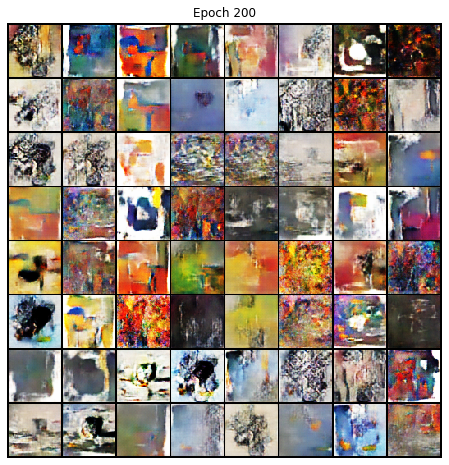

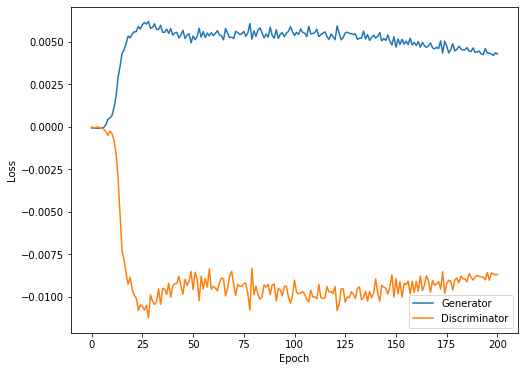

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 202 - Discriminator_Loss: -0.008859 - Generator_Loss: 0.004200


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 203 - Discriminator_Loss: -0.008440 - Generator_Loss: 0.004234


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 204 - Discriminator_Loss: -0.008444 - Generator_Loss: 0.004177


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 205 - Discriminator_Loss: -0.008781 - Generator_Loss: 0.004186


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 206 - Discriminator_Loss: -0.008409 - Generator_Loss: 0.004179


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 207 - Discriminator_Loss: -0.008326 - Generator_Loss: 0.004175


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 208 - Discriminator_Loss: -0.008455 - Generator_Loss: 0.004235


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 209 - Discriminator_Loss: -0.008562 - Generator_Loss: 0.004242


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 210 - Discriminator_Loss: -0.008672 - Generator_Loss: 0.004198


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 211 - Discriminator_Loss: -0.008419 - Generator_Loss: 0.004182


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 212 - Discriminator_Loss: -0.008158 - Generator_Loss: 0.004255


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 213 - Discriminator_Loss: -0.008560 - Generator_Loss: 0.004301


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 214 - Discriminator_Loss: -0.008629 - Generator_Loss: 0.004375


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 215 - Discriminator_Loss: -0.008387 - Generator_Loss: 0.004071


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 216 - Discriminator_Loss: -0.008465 - Generator_Loss: 0.004170


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 217 - Discriminator_Loss: -0.008250 - Generator_Loss: 0.004166


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 218 - Discriminator_Loss: -0.009171 - Generator_Loss: 0.004501


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 219 - Discriminator_Loss: -0.007905 - Generator_Loss: 0.003871


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 220 - Discriminator_Loss: -0.008415 - Generator_Loss: 0.004101


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 221 - Discriminator_Loss: -0.008475 - Generator_Loss: 0.004034


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 222 - Discriminator_Loss: -0.008661 - Generator_Loss: 0.004231


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 223 - Discriminator_Loss: -0.007876 - Generator_Loss: 0.003726


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 224 - Discriminator_Loss: -0.008496 - Generator_Loss: 0.004226


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 225 - Discriminator_Loss: -0.008204 - Generator_Loss: 0.004026


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 226 - Discriminator_Loss: -0.007988 - Generator_Loss: 0.003922


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 227 - Discriminator_Loss: -0.008236 - Generator_Loss: 0.003980


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 228 - Discriminator_Loss: -0.008125 - Generator_Loss: 0.004086


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 229 - Discriminator_Loss: -0.008443 - Generator_Loss: 0.004138


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 230 - Discriminator_Loss: -0.008227 - Generator_Loss: 0.004062


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 231 - Discriminator_Loss: -0.008383 - Generator_Loss: 0.004215


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 232 - Discriminator_Loss: -0.007821 - Generator_Loss: 0.003958


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 233 - Discriminator_Loss: -0.008114 - Generator_Loss: 0.004089


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 234 - Discriminator_Loss: -0.008246 - Generator_Loss: 0.004190


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 235 - Discriminator_Loss: -0.008153 - Generator_Loss: 0.004084


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 236 - Discriminator_Loss: -0.007901 - Generator_Loss: 0.003866


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 237 - Discriminator_Loss: -0.008466 - Generator_Loss: 0.004190


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 238 - Discriminator_Loss: -0.007644 - Generator_Loss: 0.003762


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 239 - Discriminator_Loss: -0.008267 - Generator_Loss: 0.004070


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 240 - Discriminator_Loss: -0.007811 - Generator_Loss: 0.003928


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 241 - Discriminator_Loss: -0.007866 - Generator_Loss: 0.003880


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 242 - Discriminator_Loss: -0.008084 - Generator_Loss: 0.003802


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 243 - Discriminator_Loss: -0.008187 - Generator_Loss: 0.004010


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 244 - Discriminator_Loss: -0.008010 - Generator_Loss: 0.003868


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 245 - Discriminator_Loss: -0.007988 - Generator_Loss: 0.003918


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 246 - Discriminator_Loss: -0.007915 - Generator_Loss: 0.003870


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 247 - Discriminator_Loss: -0.008205 - Generator_Loss: 0.004101


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 248 - Discriminator_Loss: -0.007818 - Generator_Loss: 0.003775


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 249 - Discriminator_Loss: -0.007860 - Generator_Loss: 0.003888


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 250 - Discriminator_Loss: -0.008044 - Generator_Loss: 0.003913


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 251 - Discriminator_Loss: -0.007630 - Generator_Loss: 0.003755


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 252 - Discriminator_Loss: -0.007790 - Generator_Loss: 0.003775


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 253 - Discriminator_Loss: -0.007887 - Generator_Loss: 0.004019


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 254 - Discriminator_Loss: -0.007895 - Generator_Loss: 0.003911


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 255 - Discriminator_Loss: -0.008369 - Generator_Loss: 0.004120


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 256 - Discriminator_Loss: -0.007683 - Generator_Loss: 0.003631


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 257 - Discriminator_Loss: -0.007600 - Generator_Loss: 0.003807


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 258 - Discriminator_Loss: -0.007610 - Generator_Loss: 0.003768


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 259 - Discriminator_Loss: -0.007789 - Generator_Loss: 0.003788


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 260 - Discriminator_Loss: -0.007944 - Generator_Loss: 0.003927


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 261 - Discriminator_Loss: -0.007637 - Generator_Loss: 0.003796


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 262 - Discriminator_Loss: -0.007889 - Generator_Loss: 0.003871


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 263 - Discriminator_Loss: -0.007825 - Generator_Loss: 0.003904


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 264 - Discriminator_Loss: -0.007891 - Generator_Loss: 0.004073


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 265 - Discriminator_Loss: -0.007716 - Generator_Loss: 0.003717


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 266 - Discriminator_Loss: -0.007637 - Generator_Loss: 0.003807


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 267 - Discriminator_Loss: -0.007685 - Generator_Loss: 0.003660


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 268 - Discriminator_Loss: -0.007602 - Generator_Loss: 0.003758


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 269 - Discriminator_Loss: -0.007810 - Generator_Loss: 0.003886


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 270 - Discriminator_Loss: -0.007787 - Generator_Loss: 0.003797


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 271 - Discriminator_Loss: -0.007651 - Generator_Loss: 0.003689


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 272 - Discriminator_Loss: -0.007642 - Generator_Loss: 0.003766


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 273 - Discriminator_Loss: -0.007696 - Generator_Loss: 0.003740


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 274 - Discriminator_Loss: -0.007449 - Generator_Loss: 0.003775


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 275 - Discriminator_Loss: -0.007723 - Generator_Loss: 0.003758


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 276 - Discriminator_Loss: -0.007709 - Generator_Loss: 0.003783


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 277 - Discriminator_Loss: -0.007571 - Generator_Loss: 0.003698


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 278 - Discriminator_Loss: -0.007572 - Generator_Loss: 0.003719


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 279 - Discriminator_Loss: -0.007580 - Generator_Loss: 0.003773


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 280 - Discriminator_Loss: -0.007469 - Generator_Loss: 0.003584


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 281 - Discriminator_Loss: -0.007651 - Generator_Loss: 0.003713


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 282 - Discriminator_Loss: -0.007919 - Generator_Loss: 0.004017


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 283 - Discriminator_Loss: -0.007781 - Generator_Loss: 0.003814


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 284 - Discriminator_Loss: -0.007445 - Generator_Loss: 0.003798


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 285 - Discriminator_Loss: -0.007239 - Generator_Loss: 0.003598


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 286 - Discriminator_Loss: -0.007769 - Generator_Loss: 0.003736


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 287 - Discriminator_Loss: -0.007585 - Generator_Loss: 0.003751


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 288 - Discriminator_Loss: -0.007755 - Generator_Loss: 0.003691


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 289 - Discriminator_Loss: -0.007479 - Generator_Loss: 0.003742


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 290 - Discriminator_Loss: -0.007314 - Generator_Loss: 0.003590


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 291 - Discriminator_Loss: -0.007992 - Generator_Loss: 0.003961


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 292 - Discriminator_Loss: -0.007234 - Generator_Loss: 0.003518


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 293 - Discriminator_Loss: -0.007346 - Generator_Loss: 0.003531


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 294 - Discriminator_Loss: -0.007386 - Generator_Loss: 0.003614


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 295 - Discriminator_Loss: -0.007593 - Generator_Loss: 0.003686


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 296 - Discriminator_Loss: -0.007452 - Generator_Loss: 0.003683


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 297 - Discriminator_Loss: -0.007599 - Generator_Loss: 0.003667


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 298 - Discriminator_Loss: -0.007258 - Generator_Loss: 0.003489


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 299 - Discriminator_Loss: -0.007521 - Generator_Loss: 0.003823


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 300 - Discriminator_Loss: -0.007716 - Generator_Loss: 0.003827


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 301 - Discriminator_Loss: -0.007118 - Generator_Loss: 0.003408


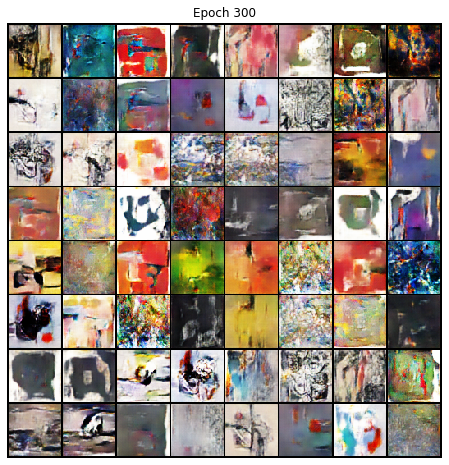

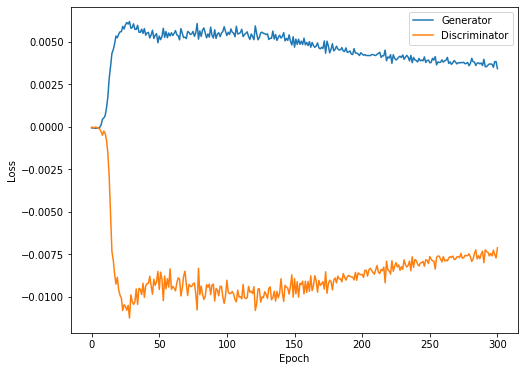

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 302 - Discriminator_Loss: -0.007513 - Generator_Loss: 0.003656


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 303 - Discriminator_Loss: -0.007442 - Generator_Loss: 0.003844


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 304 - Discriminator_Loss: -0.007257 - Generator_Loss: 0.003593


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 305 - Discriminator_Loss: -0.007223 - Generator_Loss: 0.003546


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 306 - Discriminator_Loss: -0.007342 - Generator_Loss: 0.003706


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 307 - Discriminator_Loss: -0.007256 - Generator_Loss: 0.003747


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 308 - Discriminator_Loss: -0.007300 - Generator_Loss: 0.003599


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 309 - Discriminator_Loss: -0.007011 - Generator_Loss: 0.003565


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 310 - Discriminator_Loss: -0.007422 - Generator_Loss: 0.003702


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 311 - Discriminator_Loss: -0.007291 - Generator_Loss: 0.003477


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 312 - Discriminator_Loss: -0.007162 - Generator_Loss: 0.003598


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 313 - Discriminator_Loss: -0.007513 - Generator_Loss: 0.003791


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 314 - Discriminator_Loss: -0.007134 - Generator_Loss: 0.003597


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 315 - Discriminator_Loss: -0.007174 - Generator_Loss: 0.003490


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 316 - Discriminator_Loss: -0.007358 - Generator_Loss: 0.003594


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 317 - Discriminator_Loss: -0.007099 - Generator_Loss: 0.003601


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 318 - Discriminator_Loss: -0.007302 - Generator_Loss: 0.003647


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 319 - Discriminator_Loss: -0.007229 - Generator_Loss: 0.003514


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 320 - Discriminator_Loss: -0.007213 - Generator_Loss: 0.003564


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 321 - Discriminator_Loss: -0.007113 - Generator_Loss: 0.003477


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 322 - Discriminator_Loss: -0.007000 - Generator_Loss: 0.003470


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 323 - Discriminator_Loss: -0.007248 - Generator_Loss: 0.003534


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 324 - Discriminator_Loss: -0.007085 - Generator_Loss: 0.003449


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 325 - Discriminator_Loss: -0.007356 - Generator_Loss: 0.003600


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 326 - Discriminator_Loss: -0.006982 - Generator_Loss: 0.003474


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 327 - Discriminator_Loss: -0.007287 - Generator_Loss: 0.003608


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 328 - Discriminator_Loss: -0.006934 - Generator_Loss: 0.003469


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 329 - Discriminator_Loss: -0.007003 - Generator_Loss: 0.003490


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 330 - Discriminator_Loss: -0.007160 - Generator_Loss: 0.003536


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 331 - Discriminator_Loss: -0.006977 - Generator_Loss: 0.003482


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 332 - Discriminator_Loss: -0.006967 - Generator_Loss: 0.003274


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 333 - Discriminator_Loss: -0.007114 - Generator_Loss: 0.003547


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 334 - Discriminator_Loss: -0.007245 - Generator_Loss: 0.003592


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 335 - Discriminator_Loss: -0.007162 - Generator_Loss: 0.003551


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 336 - Discriminator_Loss: -0.006990 - Generator_Loss: 0.003539


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 337 - Discriminator_Loss: -0.007206 - Generator_Loss: 0.003584


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 338 - Discriminator_Loss: -0.006804 - Generator_Loss: 0.003304


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 339 - Discriminator_Loss: -0.007153 - Generator_Loss: 0.003653


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 340 - Discriminator_Loss: -0.007009 - Generator_Loss: 0.003497


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 341 - Discriminator_Loss: -0.007267 - Generator_Loss: 0.003551


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 342 - Discriminator_Loss: -0.006814 - Generator_Loss: 0.003401


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 343 - Discriminator_Loss: -0.007289 - Generator_Loss: 0.003733


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 344 - Discriminator_Loss: -0.006843 - Generator_Loss: 0.003462


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 345 - Discriminator_Loss: -0.006798 - Generator_Loss: 0.003287


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 346 - Discriminator_Loss: -0.006961 - Generator_Loss: 0.003403


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 347 - Discriminator_Loss: -0.007437 - Generator_Loss: 0.003745


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 348 - Discriminator_Loss: -0.006853 - Generator_Loss: 0.003379


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 349 - Discriminator_Loss: -0.006882 - Generator_Loss: 0.003450


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 350 - Discriminator_Loss: -0.006790 - Generator_Loss: 0.003397


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 351 - Discriminator_Loss: -0.006935 - Generator_Loss: 0.003428


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 352 - Discriminator_Loss: -0.006893 - Generator_Loss: 0.003444


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 353 - Discriminator_Loss: -0.006938 - Generator_Loss: 0.003545


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 354 - Discriminator_Loss: -0.006939 - Generator_Loss: 0.003408


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 355 - Discriminator_Loss: -0.006775 - Generator_Loss: 0.003328


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 356 - Discriminator_Loss: -0.006794 - Generator_Loss: 0.003323


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 357 - Discriminator_Loss: -0.006648 - Generator_Loss: 0.003263


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 358 - Discriminator_Loss: -0.006734 - Generator_Loss: 0.003386


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 359 - Discriminator_Loss: -0.006744 - Generator_Loss: 0.003346


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 360 - Discriminator_Loss: -0.007127 - Generator_Loss: 0.003548


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 361 - Discriminator_Loss: -0.006911 - Generator_Loss: 0.003481


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 362 - Discriminator_Loss: -0.006528 - Generator_Loss: 0.003193


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 363 - Discriminator_Loss: -0.006872 - Generator_Loss: 0.003443


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 364 - Discriminator_Loss: -0.006928 - Generator_Loss: 0.003454


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 365 - Discriminator_Loss: -0.006699 - Generator_Loss: 0.003231


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 366 - Discriminator_Loss: -0.006599 - Generator_Loss: 0.003226


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 367 - Discriminator_Loss: -0.006951 - Generator_Loss: 0.003510


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 368 - Discriminator_Loss: -0.006546 - Generator_Loss: 0.003311


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 369 - Discriminator_Loss: -0.006797 - Generator_Loss: 0.003403


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 370 - Discriminator_Loss: -0.006734 - Generator_Loss: 0.003374


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 371 - Discriminator_Loss: -0.006581 - Generator_Loss: 0.003385


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 372 - Discriminator_Loss: -0.006806 - Generator_Loss: 0.003329


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 373 - Discriminator_Loss: -0.006920 - Generator_Loss: 0.003481


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 374 - Discriminator_Loss: -0.006568 - Generator_Loss: 0.003297


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 375 - Discriminator_Loss: -0.006880 - Generator_Loss: 0.003365


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 376 - Discriminator_Loss: -0.006960 - Generator_Loss: 0.003367


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 377 - Discriminator_Loss: -0.006355 - Generator_Loss: 0.003248


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 378 - Discriminator_Loss: -0.006395 - Generator_Loss: 0.003216


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 379 - Discriminator_Loss: -0.006743 - Generator_Loss: 0.003323


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 380 - Discriminator_Loss: -0.006518 - Generator_Loss: 0.003417


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 381 - Discriminator_Loss: -0.006840 - Generator_Loss: 0.003299


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 382 - Discriminator_Loss: -0.006561 - Generator_Loss: 0.003229


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 383 - Discriminator_Loss: -0.006685 - Generator_Loss: 0.003446


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 384 - Discriminator_Loss: -0.006605 - Generator_Loss: 0.003370


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 385 - Discriminator_Loss: -0.006682 - Generator_Loss: 0.003261


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 386 - Discriminator_Loss: -0.006681 - Generator_Loss: 0.003392


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 387 - Discriminator_Loss: -0.006608 - Generator_Loss: 0.003302


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 388 - Discriminator_Loss: -0.006639 - Generator_Loss: 0.003464


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 389 - Discriminator_Loss: -0.006269 - Generator_Loss: 0.003199


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 390 - Discriminator_Loss: -0.006654 - Generator_Loss: 0.003353


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 391 - Discriminator_Loss: -0.006612 - Generator_Loss: 0.003392


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 392 - Discriminator_Loss: -0.006466 - Generator_Loss: 0.003278


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 393 - Discriminator_Loss: -0.006759 - Generator_Loss: 0.003415


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 394 - Discriminator_Loss: -0.006408 - Generator_Loss: 0.003243


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 395 - Discriminator_Loss: -0.006421 - Generator_Loss: 0.003248


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 396 - Discriminator_Loss: -0.006681 - Generator_Loss: 0.003245


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 397 - Discriminator_Loss: -0.006614 - Generator_Loss: 0.003382


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 398 - Discriminator_Loss: -0.006396 - Generator_Loss: 0.003066


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 399 - Discriminator_Loss: -0.006549 - Generator_Loss: 0.003190


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 400 - Discriminator_Loss: -0.006618 - Generator_Loss: 0.003324


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 401 - Discriminator_Loss: -0.006305 - Generator_Loss: 0.003233


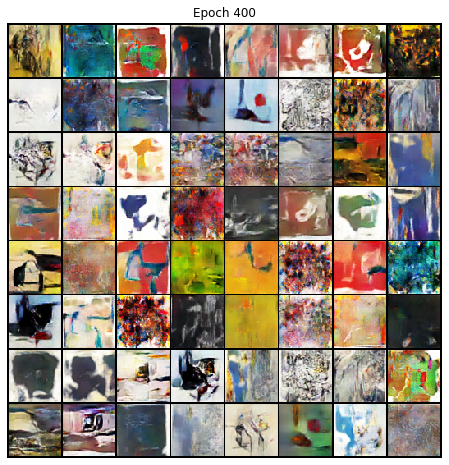

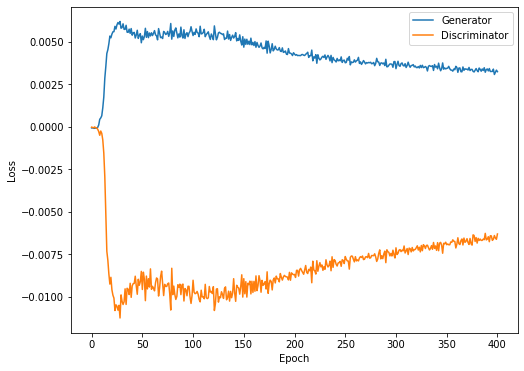

In [9]:
img_list = []
g_losses, d_losses = [], []
total = 0

def plot_loss(G_losses, D_losses):
    plt.figure(figsize=(8, 6))
    plt.plot(G_losses,label="Generator")
    plt.plot(D_losses,label="Discriminator")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

def plot_images(imgs, epoch):
    plt.subplots(figsize=(10, 8))
    plt.axis("off")
    plt.title(f"Epoch {epoch}")
    raw_images = unnorm(imgs, *norm)
    plt.imshow(make_grid(raw_images[:BATCH_SIZE], nrow=8).permute(1, 2, 0).clamp(0,1))
    plt.show()

for epoch in tqdm(range(401)):
    g_loss = 0.0
    d_loss = 0.0
    total = 0
    for i, data in tqdm(enumerate(dataloader, 0), total=len(dataloader)):
        for _ in range(1):
            # Train Discriminator
            discriminator.zero_grad()
            # Real
            real_images = data[0].to(DEVICE)
            batch_size = real_images.size(0)
            label = torch.full((batch_size,), real_label, dtype=torch.float, device=DEVICE)
            output_real = discriminator(real_images).view(-1)
            # Fake
            noise = torch.randn(batch_size, 100, 1, 1, device=DEVICE)
            fake = generator(noise)
            label.fill_(fake_label)
            output_fake = discriminator(fake.detach()).view(-1)
            d_wloss = torch.mean(output_fake - output_real)
            d_wloss.backward()
            discriminator_optimizer.step()

            for params in discriminator.parameters():
                params.data.clamp_(-0.01, +0.01)

        # Train Generator
        generator.zero_grad()
        output = discriminator(fake).view(-1)
        g_wloss = -torch.mean(output)
        g_wloss.backward()
        generator_optimizer.step()

        g_loss += g_wloss.item()
        d_loss += d_wloss.item()
        total += batch_size

    avg_g_loss = g_loss / total
    g_losses.append(avg_g_loss)
    avg_d_loss = d_loss / total
    d_losses.append(avg_d_loss)

    print(f"Epoch: {epoch + 1} - Discriminator_Loss: {avg_d_loss:.6f} - Generator_Loss: {avg_g_loss:.6f}")

    with torch.no_grad():
        fake = generator(fixed_noise).detach().cpu()
    imgs = vutils.make_grid(unnorm(fake, *norm), padding=2, normalize=True)
    img_list.append(imgs)
    if epoch % 100 == 0:
        plot_images(fake, epoch)
        plot_loss(g_losses, d_losses)